In [177]:
from doctr.datasets import CORD, SROIE
from matplotlib import pyplot as plt
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
from matplotlib import pyplot as plt
import cv2
from torchvision import transforms
from tqdm import tqdm

In [3]:
cord_train_set = CORD(train=True, download=True)

In [144]:
img, target = cord_train_set[2]

In [117]:
def rotate_image(tensor_img, angle):
    image = tensor_img.permute(1,2,0).numpy()
    height, width = image.shape[:2]
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
    return torch.tensor(cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))).permute(2,0,1)

In [118]:
def show_tensor(tensor_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(tensor_image.permute(1,2,0));

In [112]:
def sobel_conv2d():
    weights = torch.Tensor([[1, 2, 1], 
                            [0, 0, 0], 
                            [-1, -2, -1]]).unsqueeze(0).unsqueeze(0) # оператор Собеля
    weights.requires_grad = True
    conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size=3, padding=1, bias=False)
    with torch.no_grad():
        conv.weight = nn.Parameter(weights)
    return conv

In [133]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1)
])

In [134]:
conv = sobel_conv2d()

## Один случай

In [161]:
rotated_img = rotate_image(img, 30)

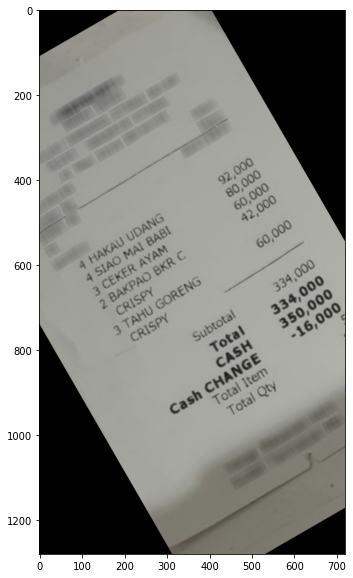

In [162]:
show_tensor(rotated_img)

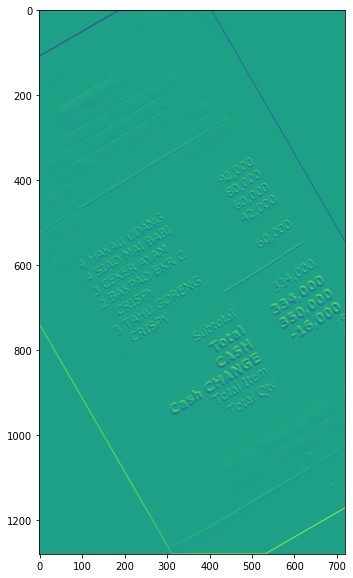

In [163]:
gray_image = transform(rotated_img)
conv_image = conv(gray_image.unsqueeze(0)).detach()[0]
show_tensor(conv_image)

## Прокручиваем картинку на 360

In [172]:
img, target = cord_train_set[200]

In [173]:
results = []

for angle in range(360):
    rotated_img = rotate_image(img, angle)
    gray_image = transform(rotated_img)
    conv_image = conv(gray_image.unsqueeze(0))
    results.append(conv_image.sum().detach().numpy())

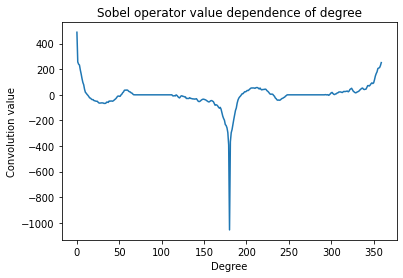

In [174]:
plt.plot(np.arange(0,360),results)
plt.xlabel('Degree')
plt.ylabel('Convolution value');
plt.title('Sobel operator value dependence of degree');

## Прокручиваем все картинки и усредняем

In [181]:
total_result = []

for idx in tqdm(range(100)): # надо бы сделать len(cord_train_set), но долго ждать, сделаю потом
    img, target = cord_train_set[idx]
    
    results = []

    for angle in range(0, 360, 25):
        rotated_img = rotate_image(img, angle)
        gray_image = transform(rotated_img)
        conv_image = conv(gray_image.unsqueeze(0))
        results.append(conv_image.sum().detach().numpy())
    
    total_result.append(results)

100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


In [182]:
total_result_array = np.array(total_result)

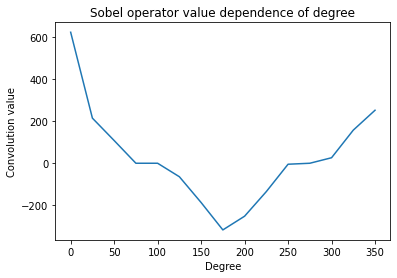

In [185]:
plt.plot(np.arange(0, 360, 25),total_result_array.mean(axis = 0))
plt.xlabel('Degree')
plt.ylabel('Convolution value');
plt.title('Sobel operator value dependence of degree');

### Вывод: 

Да, гипотеза работает, если использовать оператор Собеля для поиска горизонтальных линий, то вертикальная картинка даёт наилучший результат